In [1]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from math import sqrt
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.constants import g, pi

#plotting
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from itertools import count

import warnings; warnings.simplefilter('ignore')


%matplotlib inline

In [17]:
# import GRDC dataset

#dss = xr.open_dataset('grdc_northeast/GRDC-Daily.nc')
dss = xr.open_dataset('grdc_connecticut/GRDC-Daily.nc')
#dss2 = dss.sel(time=slice("2018-01-01", "2020-01-01"))              # select the period you want for the analysis
#dss2 = dss.sel(time=slice("2019-01-01", "2020-01-01")).where(dss.station_name=="NEAR WILLIMANTIC, CONN.", drop=True)
dss2 = dss.sel(time=slice("2017-01-01", "2020-01-01")).where(dss.station_name=="NORTH STRATFORD, NH", drop=True)
dss2

<xarray.Dataset>
Dimensions:              (time: 1096, id: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2017-01-01 ... 2020-01-01
  * id                   (id) int32 4147463
Data variables:
    runoff_mean          (time, id) float32 45.87 44.17 43.33 ... 31.72 31.72
    area                 (id) float32 2.069e+03
    country              (id) object 'US'
    geo_x                (id) float32 -71.63
    geo_y                (id) float32 44.75
    geo_z                (id) float32 268.3
    owneroforiginaldata  (id) object 'United States of America - US Geologica...
    river_name           (id) object 'CONNECTICUT RIVER'
    station_name         (id) object 'NORTH STRATFORD, NH'
    timezone             (id) float32 5.0
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 21/09/2021
    missing_value:  -999.000

In [3]:
# use Thompsonville, West Lebanon, North Stratford, Passumpsic
dss

<xarray.Dataset>
Dimensions:              (time: 42579, id: 8)
Coordinates:
  * time                 (time) datetime64[ns] 1904-03-31 ... 2020-10-26
  * id                   (id) int32 4147460 4147461 4147462 ... 4147475 4147480
Data variables:
    runoff_mean          (time, id) float32 ...
    area                 (id) float32 ...
    country              (id) object ...
    geo_x                (id) float32 ...
    geo_y                (id) float32 ...
    geo_z                (id) float32 ...
    owneroforiginaldata  (id) object ...
    river_name           (id) object ...
    station_name         (id) object 'THOMPSONVILLE, CT' ... 'RAINBOW, CONN.'
    timezone             (id) float32 ...
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 21/09/2021
    missing_value:  -999.000

In [18]:
# import GloFAS dataset
glofas = xr.open_dataset('glofas_ct_river_basin.grib', engine='cfgrib')
glofas_ds = glofas.sel(time=slice("2017-01-01", "2020-01-01"))
ds3 = glofas_ds.sel(longitude=360+dss2.geo_x, latitude=dss2.geo_y, method='nearest')
ds3

<xarray.Dataset>
Dimensions:     (time: 1096, id: 1)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2020-01-01
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (id) float64 44.7
    longitude   (id) float64 288.4
    valid_time  (time) datetime64[ns] ...
  * id          (id) int32 4147463
Data variables:
    dis24       (time, id) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-18T16:52 GRIB to CDM+CF via cfgrib-0.9.9...

In [5]:
bias = np.array([-13.7, 2.8, -9.4, -327.1, -112.3])
KGE = np.array([0.32,0.76,0.56,0.44,0.47])

bias.mean(), KGE.mean()

(-91.94000000000001, 0.51)

In [19]:
# Calculate Bias 
ds0 = ds3.dis24.values - dss2.runoff_mean

#bias0 = abs(ds0.sum() / len(ds0))
bias0 = ds0.sum() / len(ds0)

bias0

<xarray.DataArray 'runoff_mean' ()>
array(2.78818841)

In [20]:
ds0 = ds3.dis24.values - dss2.runoff_mean.values
N = len(ds0)

In [5]:
dss2.runoff_mean.max()

<xarray.DataArray 'runoff_mean' ()>
array(nan)

In [21]:
# use this instead if there are missing observation values
ds3_new = ds3.dis24[:,0][dss2.runoff_mean.notnull()[:,0]]
dss2_new = dss2.runoff_mean[:,0][dss2.runoff_mean.notnull()[:,0]]

r = stats.pearsonr(dss2_new,ds3_new)[0]
beta = ds3_new.mean()/dss2_new.mean()
gamma = (ds3_new.std()/ds3_new.mean())/(dss2_new.std()/dss2_new.mean())

N = len(ds3.dis24.values)

KGE1 = 1 - np.sqrt(((r-1)**2)+((beta-1)**2)+((gamma-1)**2))
KGE1

<xarray.DataArray ()>
array(0.76239205)
Coordinates:
    step       timedelta64[ns] 1 days
    surface    float64 0.0
    latitude   float64 44.7
    longitude  float64 288.4
    id         int32 4147463

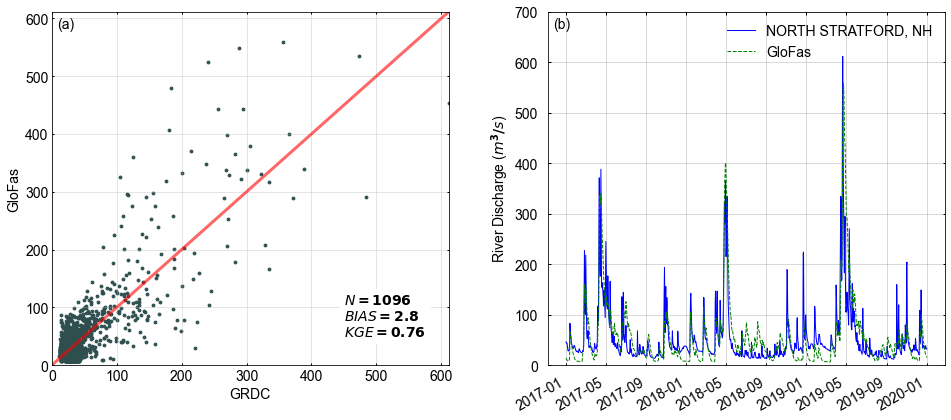

In [29]:
fig, ax_lst = plt.subplots(1, 2,figsize=(16., 6.5), gridspec_kw={'hspace': 0.2, 'wspace': 0.25})
fig.tight_layout()

def label_subplots(ax_lst, *, upper_case=False,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), ('('+chr(j)+')' for j in count(start_ord))):
        ax.annotate(lab, (0.07, 1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='regular')


label_subplots(ax_lst, upper_case=False)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14


# Figure 1

#ax.plot(ds3.dis24, dss2.runoff_mean, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[0].plot([0, dss2.runoff_mean.max()], [0, dss2.runoff_mean.max()], linestyle='-', linewidth=3, color='red', 
               alpha=0.6, label='$Y=X$')

#ax_lst[0,0].scatter(x_2, y_2, c=z_2, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[0].scatter(dss2.runoff_mean, ds3.dis24, s=8, label='data',color='darkslategrey')

ax_lst[0].set_xlabel('GRDC')
#ax_lst[0,0].set_ylabel('$C_{d} = 1.2 \cdot 10^{-3}$ Parametrization $u_{10n}$ (m/s)', fontsize=12)
#ax_lst[0,0].ylabel('Power Law $u_{10n}$ (m/s)', fontsize=14)
ax_lst[0].set_ylabel('GloFas')

ax_lst[0].set_xlim(0,dss2.runoff_mean.max())
ax_lst[0].set_ylim(0,dss2.runoff_mean.max())
ax_lst[0].grid(linestyle='-', alpha=0.4)

ax_lst[0].xaxis.set_tick_params(which='major', size=2, width=1, direction='in', top='on')
ax_lst[0].yaxis.set_tick_params(which='major', size=2, width=1, direction='in', right='on')

props1 = dict(boxstyle='square', facecolor='white', alpha=1,edgecolor='white')

textstr1 = '\n'.join((r'$N=%i$' % (N,), r'$BIAS=%.1f$' % (bias0,), (r'$KGE=%.2f$' % (KGE1,))))

ax_lst[0].text(450,50,textstr1,bbox=props1)

"""
props2 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr2 = '\n'.join((r'$N=%i$' % (N2,), r'$\rho=%.3f$' % (rho2,), r'$RMSE=%.3f$' % (rmse2,), r'$BIAS=%.3f$' % (bias2,),
                     r'$SI=%.3f$' % (si2,), r'$Y=%.3fX + %.3f$' % (a2,b2,)))

ax_lst[0,0].text(0.2,4.1,textstr2,fontsize=9,bbox=props2)
"""

# Figure 2

ax_lst[1].plot_date(dss2.time,dss2.runoff_mean,linestyle='-',marker='',linewidth=1.,
                    color="blue",label=dss.station_name.values[3])
ax_lst[1].plot_date(ds3.time,ds3.dis24,linestyle='--',linewidth=1.,marker="",color='green',label="GloFas")
ax_lst[1].legend(frameon=False,loc='upper right')
ax_lst[1].grid(alpha=0.6)
ax_lst[1].set_ylim(0,700)

ax_lst[1].xaxis.set_tick_params(which='major', size=2.5, width=1, direction='in', top='on',pad=10.)
ax_lst[1].yaxis.set_tick_params(which='major', size=2.5, width=1, direction='in', right='on',pad=10.)

ax_lst[1].set_ylabel("River Discharge ($m^{3}/s$)")

for label in ax_lst[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
    
plt.savefig('enve5810_river_discharge_validation_northstrat.pdf', dpi=600, bbox_inches='tight')

In [19]:
### Nash–Sutcliffe model efficiency coefficient

NSE = 1 - ((np.sum(dss2.runoff_mean.values[:,0]-ds3.dis24.values[:,0])**2)/(np.sum(dss2.runoff_mean.values[:,0]-dss2.runoff_mean.mean().values)**2))
NSE

-88674221505322.92